In [6]:
import pandas as pd
import numpy as np
from rich.jupyter import display
from torch.distributions.constraints import positive

data = pd.read_csv("sp500_returns_with_tickers.csv", index_col="date")

cap_data = pd.read_csv("sp500_market_caps.csv", index_col="date")

cap_data = cap_data * 1000

cap_data_numeric = cap_data.apply(pd.to_numeric, errors='coerce')
cap_data_numeric = cap_data_numeric.fillna(0)
weight_data = cap_data_numeric.div(cap_data_numeric.sum(axis=1), axis=0)
row_sums = weight_data.sum(axis=1)

data = data[weight_data.columns]

data_numeric = data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Now compute returns:
sp500_returns = (data_numeric * weight_data).sum(axis=1)

active_mask = cap_data_numeric > 0

# Number of active stocks per month:
n_active_stocks = active_mask.sum(axis=1)

# Equal weight data:
equal_weight_data = active_mask.div(n_active_stocks, axis=0)

# Equal-weighted SP500 returns:
sp500_ew_returns = (data_numeric * equal_weight_data).sum(axis=1)

innovation_returns = sp500_returns - sp500_ew_returns
innovation_weights = weight_data - equal_weight_data

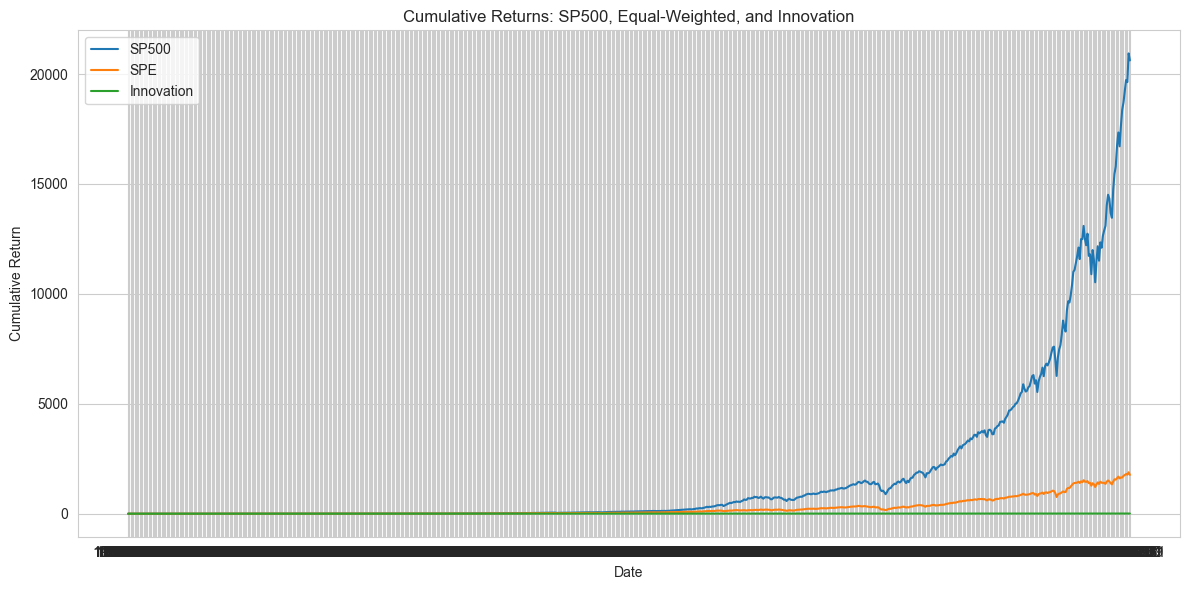

In [8]:
import matplotlib.pyplot as plt

# Combine all return series into one DataFrame
returns_df = pd.DataFrame({
    "SP500": sp500_returns,
    "SPE": sp500_ew_returns,
    "Innovation": innovation_returns
})

# Drop any NaNs (especially at the start)
returns_df = returns_df.dropna()

# Convert simple returns to cumulative returns (starting at 1)
cumulative_returns = (1 + returns_df).cumprod()

# Plot
plt.figure(figsize=(12, 6))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)

plt.title("Cumulative Returns: SP500, Equal-Weighted, and Innovation")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

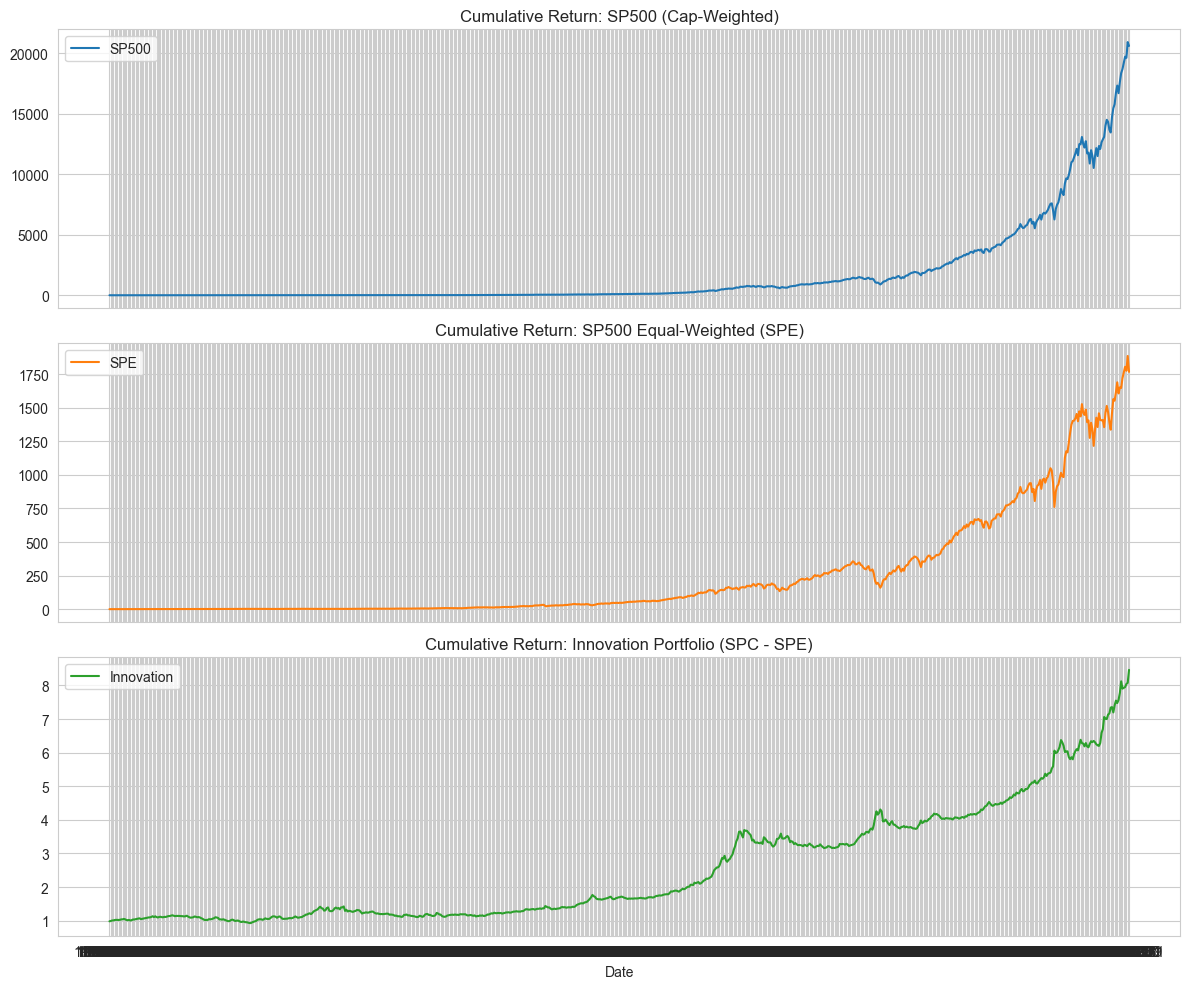

In [9]:
import matplotlib.pyplot as plt

# Step 1: Compute cumulative returns if you haven't already
returns_df = pd.DataFrame({
    "SP500": sp500_returns,
    "SPE": sp500_ew_returns,
    "Innovation": innovation_returns
}).dropna()

cumulative_returns = (1 + returns_df).cumprod()

# Step 2: Plot each series in a stacked subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

titles = ["Cumulative Return: SP500 (Cap-Weighted)",
          "Cumulative Return: SP500 Equal-Weighted (SPE)",
          "Cumulative Return: Innovation Portfolio (SPC - SPE)"]

for i, col in enumerate(cumulative_returns.columns):
    axes[i].plot(cumulative_returns.index, cumulative_returns[col], label=col, color='C'+str(i))
    axes[i].set_title(titles[i])
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

Positive return months: 460
Avg positive return: 0.012794758950298924
Negative return months: 320
Avg negative return: -0.011373790421783783


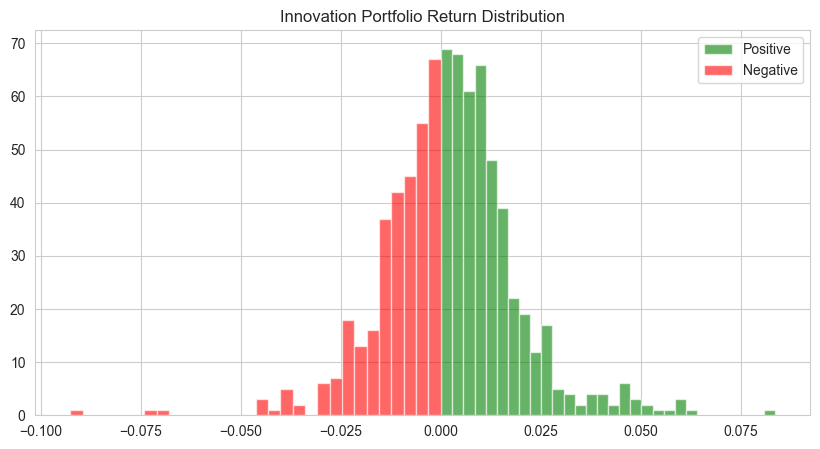

In [11]:
# Tag direction
innovation_series = returns_df["Innovation"]
positive_returns = innovation_series[innovation_series > 0]
negative_returns = innovation_series[innovation_series < 0]

# Count and average magnitude
print("Positive return months:", len(positive_returns))
print("Avg positive return:", positive_returns.mean())
print("Negative return months:", len(negative_returns))
print("Avg negative return:", negative_returns.mean())

# Optional: histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(positive_returns, bins=30, alpha=0.6, label="Positive", color='green')
plt.hist(negative_returns, bins=30, alpha=0.6, label="Negative", color='red')
plt.title("Innovation Portfolio Return Distribution")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Compute long/short legs of innovation weights
positive_leg = innovation_weights.clip(lower=0).sum(axis=1)
negative_leg = innovation_weights.clip(upper=0).sum(axis=1)

# Combine into a DataFrame
innovation_weight_magnitude = pd.DataFrame({
    "Positive Leg": positive_leg,
    "Negative Leg": negative_leg,
    "Total Abs Weight": positive_leg - negative_leg  # should always be positive
})

# Optional: net exposure (should be near 0 by construction)
innovation_weight_magnitude["Net"] = positive_leg + negative_leg

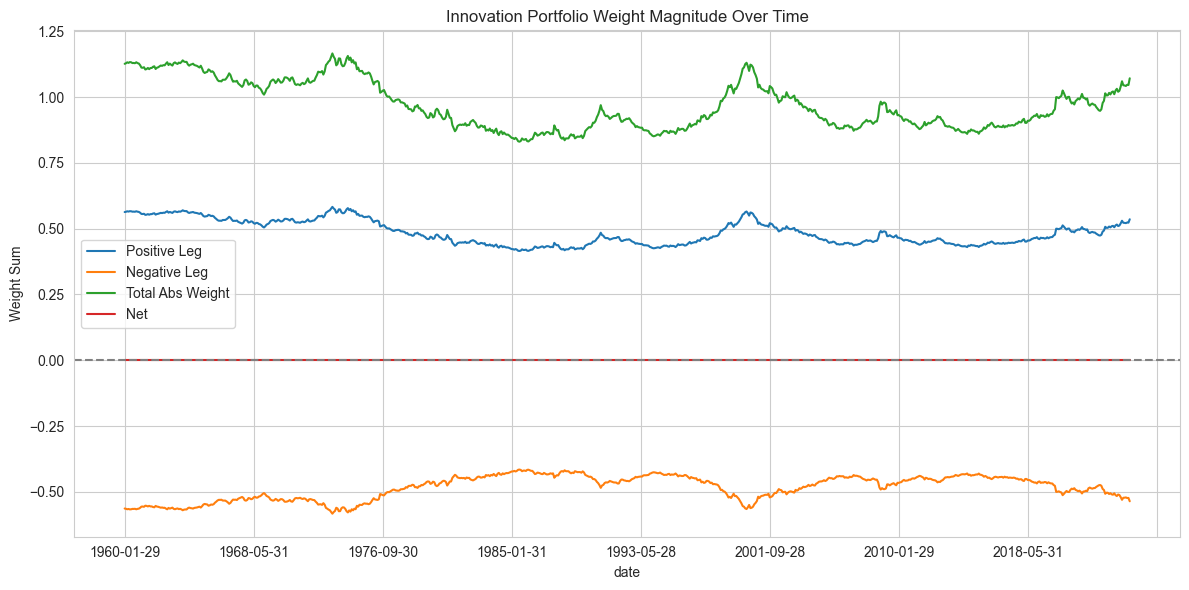

In [13]:
innovation_weight_magnitude.plot(figsize=(12, 6), title="Innovation Portfolio Weight Magnitude Over Time")
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Weight Sum")
plt.grid(True)
plt.tight_layout()
plt.show()

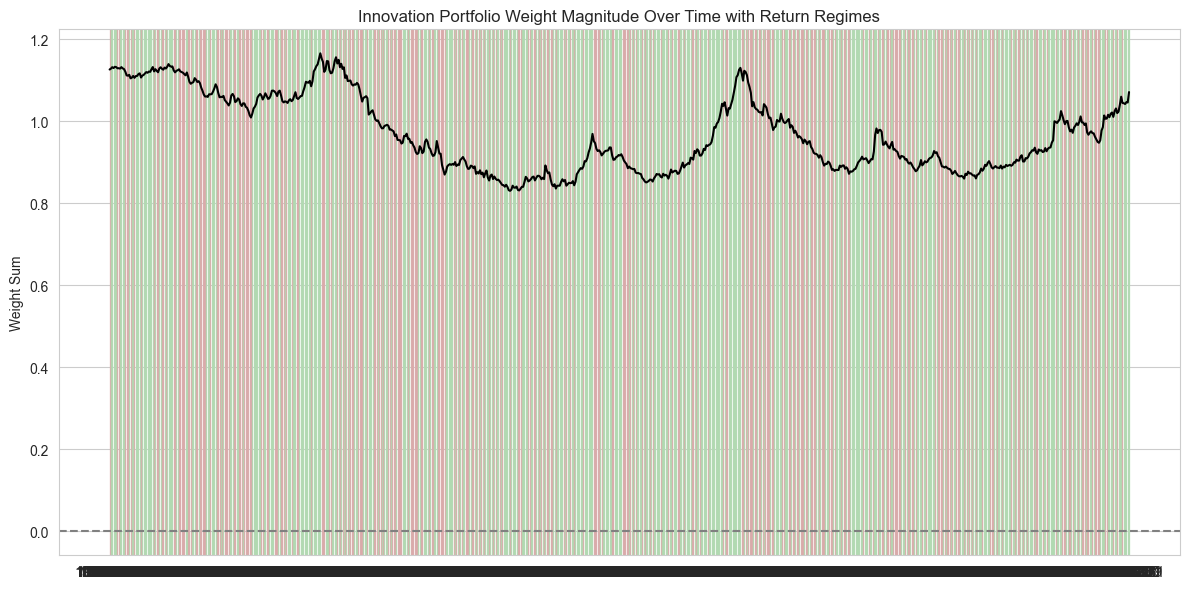

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the innovation weight magnitude
ax.plot(innovation_weight_magnitude.index, innovation_weight_magnitude["Total Abs Weight"], label="Total Abs Weight", color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_title("Innovation Portfolio Weight Magnitude Over Time with Return Regimes")
ax.set_ylabel("Weight Sum")
ax.grid(True)

# Add more visible background shading
for date, value in innovation_series.items():
    color = 'lightgreen' if value > 0 else 'lightcoral'
    ax.axvspan(date, date, color=color, alpha=0.35)

plt.tight_layout()
plt.show()

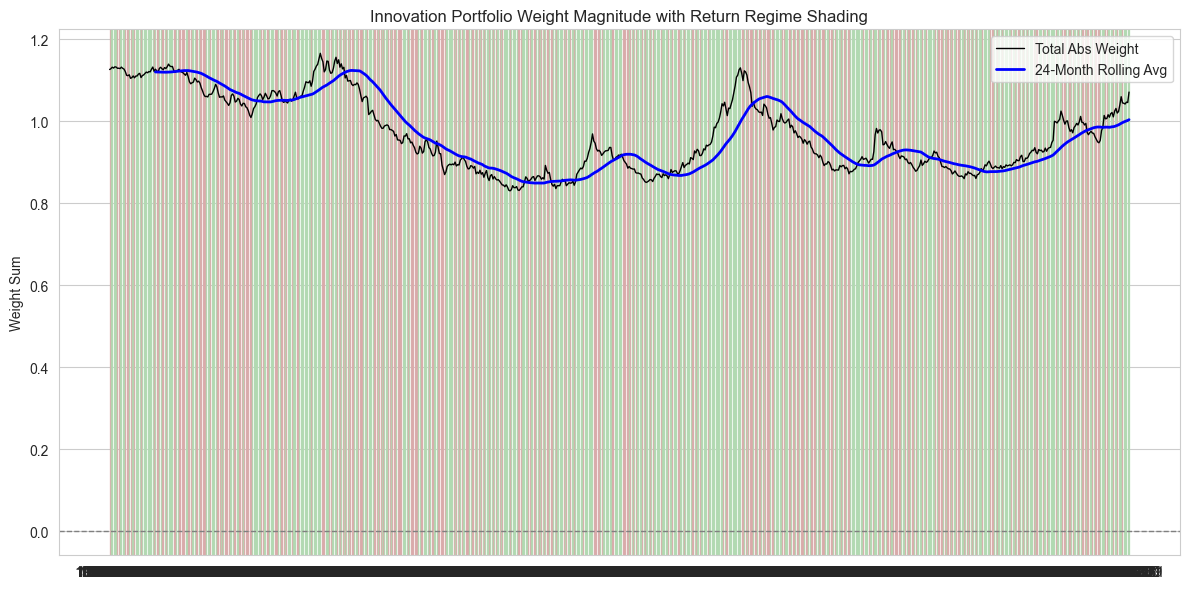

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

# Extract the series
abs_weight = innovation_weight_magnitude["Total Abs Weight"]
rolling_avg = abs_weight.rolling(window=36).mean()

# Plot both lines
ax.plot(abs_weight.index, abs_weight, label="Total Abs Weight", color='black', linewidth=1)
ax.plot(rolling_avg.index, rolling_avg, label="24-Month Rolling Avg", color='blue', linewidth=2)

# Add horizontal line at 0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add background shading for Innovation return sign
for date, value in innovation_series.items():
    color = 'lightgreen' if value > 0 else 'lightcoral'
    ax.axvspan(date, date, color=color, alpha=0.35)

# Labels and legend
ax.set_title("Innovation Portfolio Weight Magnitude with Return Regime Shading")
ax.set_ylabel("Weight Sum")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

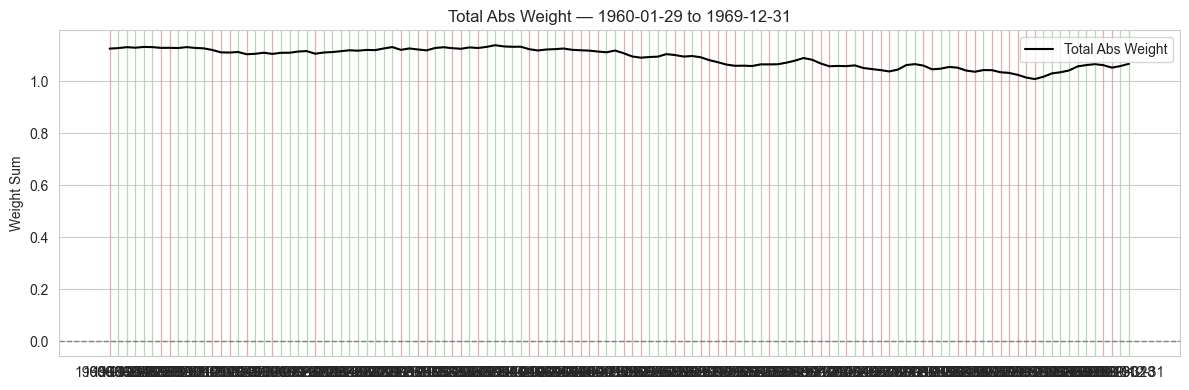

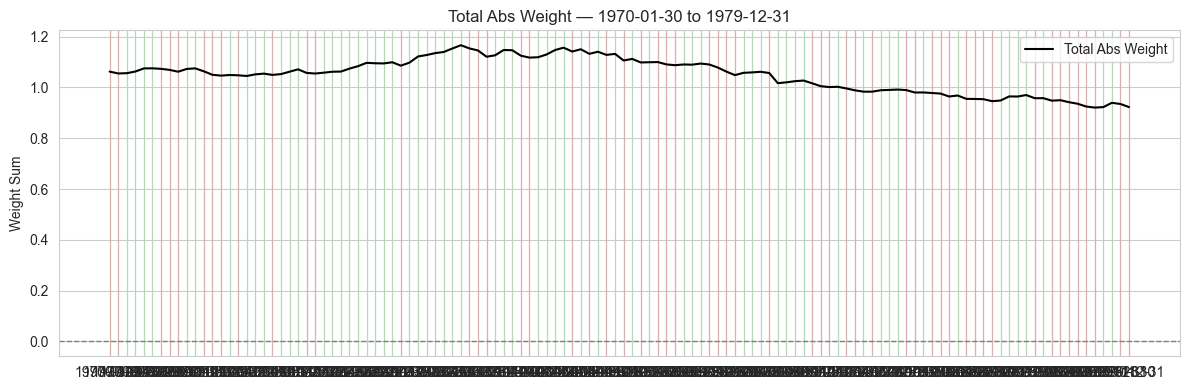

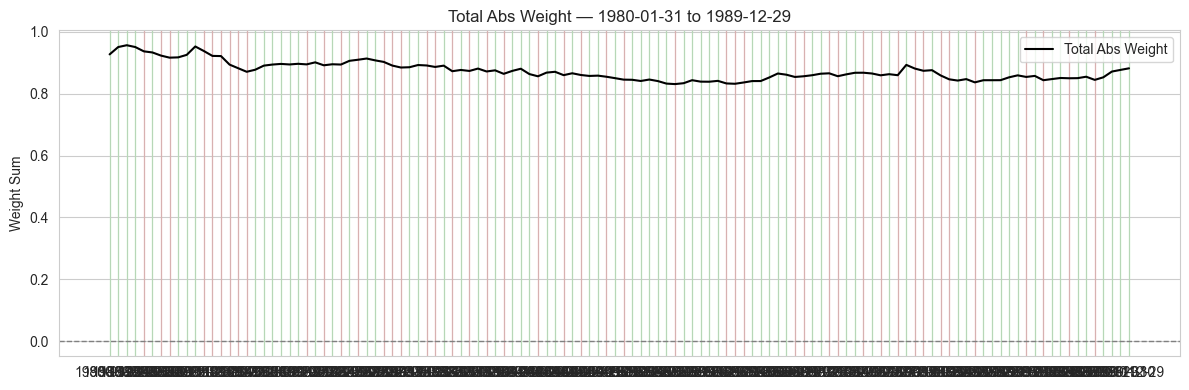

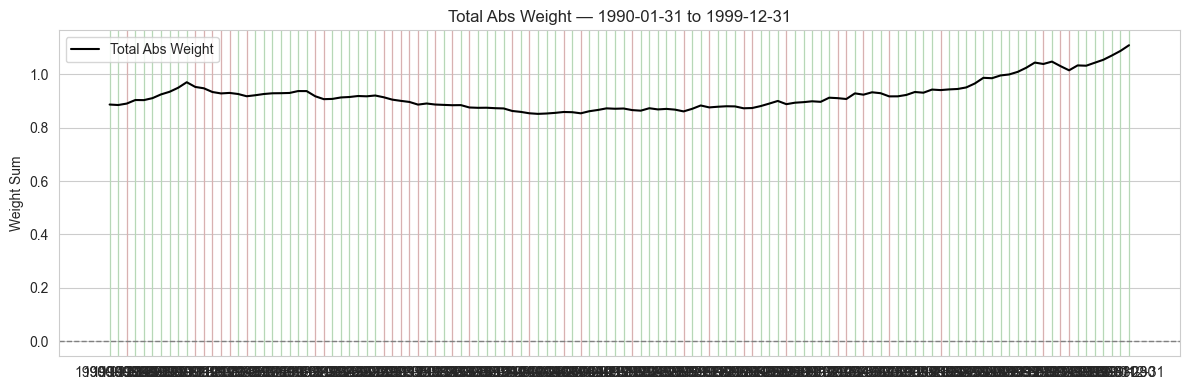

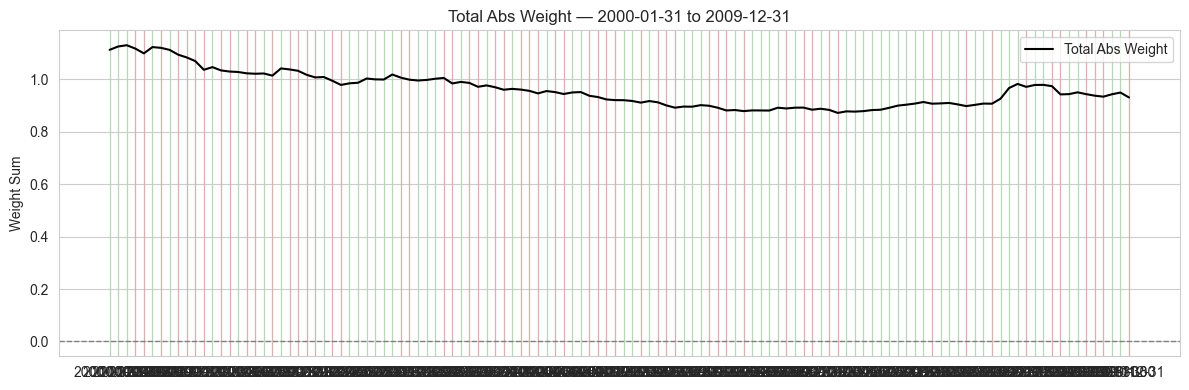

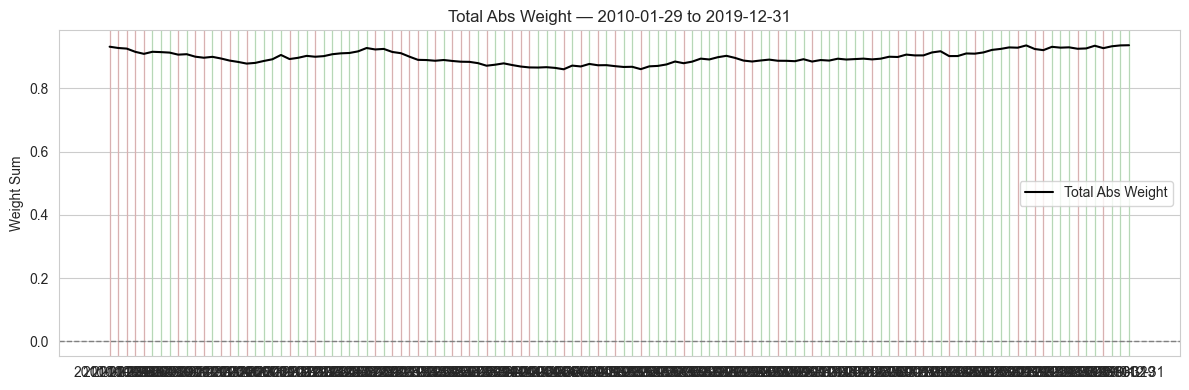

In [22]:
import matplotlib.pyplot as plt

# Use raw Total Abs Weight
abs_weight = innovation_weight_magnitude["Total Abs Weight"]
dates = abs_weight.index

# Number of months per chunk
chunk_size = 120
n_chunks = len(abs_weight) // chunk_size

# Make individual 24-month plots
for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = start_idx + chunk_size
    if end_idx > len(abs_weight):
        break

    # Slice for this chunk
    chunk_weights = abs_weight.iloc[start_idx:end_idx]
    chunk_dates = chunk_weights.index
    chunk_returns = innovation_series.loc[chunk_dates]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(chunk_dates, chunk_weights, color='black', label='Total Abs Weight')

    # Background shading based on return sign
    for date, value in chunk_returns.items():
        color = 'lightgreen' if value > 0 else 'lightcoral'
        ax.axvspan(date, date, color=color, alpha=0.35)

    ax.set_title(f"Total Abs Weight — {chunk_dates[0]} to {chunk_dates[-1]}")
    ax.set_ylabel("Weight Sum")
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [32]:
positive_returns = innovation_series[innovation_series > 0]
negative_returns = innovation_series[innovation_series < 0]

print("Mean Positive Return:", positive_returns.mean())
print("Mean Negative Return:", negative_returns.mean())
print("Std Positive:", positive_returns.std())
print("Std Negative:", negative_returns.std())
print("Skewness:", innovation_series.skew())
print("Kurtosis:", innovation_series.kurtosis())

Mean Positive Return: 0.012794758950298924
Mean Negative Return: -0.011373790421783783
Std Positive: 0.011945991477740994
Std Negative: 0.011183720865679108
Skewness: 0.032721400532903434
Kurtosis: 3.6546517660623214


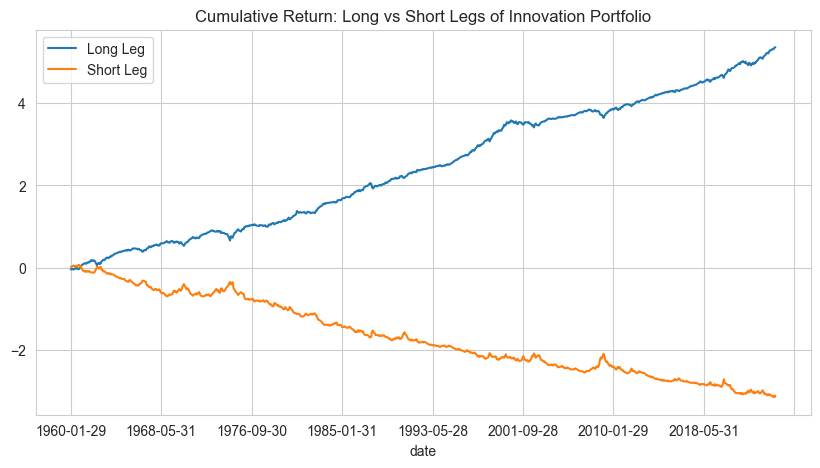

In [28]:
long_weights = innovation_weights.clip(lower=0)
short_weights = innovation_weights.clip(upper=0)

long_returns = (data_numeric * long_weights).sum(axis=1)
short_returns = (data_numeric * short_weights).sum(axis=1)

(long_returns.cumsum()).plot(label="Long Leg", figsize=(10, 5))
(short_returns.cumsum()).plot(label="Short Leg")
plt.title("Cumulative Return: Long vs Short Legs of Innovation Portfolio")
plt.legend()
plt.grid(True)
plt.show()

<Axes: title={'center': 'Concentration in Long vs. Short Legs'}, xlabel='date'>

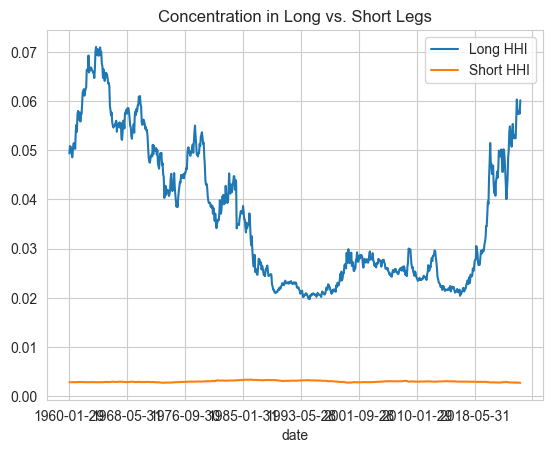

In [29]:
def hhi(weights):
    weights = weights / weights.sum()
    return (weights ** 2).sum()

long_hhi = long_weights.apply(hhi, axis=1)
short_hhi = short_weights.abs().apply(hhi, axis=1)

pd.DataFrame({"Long HHI": long_hhi, "Short HHI": short_hhi}).plot(title="Concentration in Long vs. Short Legs")

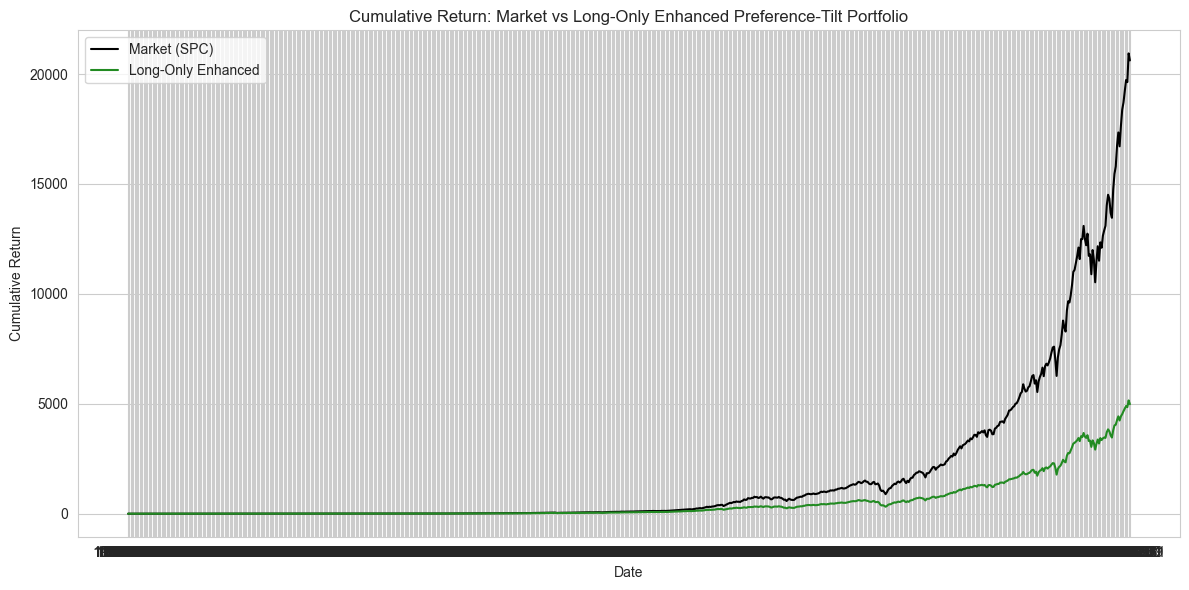

In [68]:
# 1. Get absolute value of Innovation weights (so we boost both over- and underweighted names)
long_only_tilt = innovation_weights.clip(lower=0)

# 2. Add to equal weight
enhanced_weights = equal_weight_data + long_only_tilt

# 3. Normalize to sum to 1 (so it's a valid portfolio)
enhanced_weights = enhanced_weights.div(enhanced_weights.sum(axis=1), axis=0)

# 4. Align data
returns_aligned = data_numeric[enhanced_weights.columns]

# 5. Compute return of long-only enhanced portfolio
long_only_enhanced_returns = (returns_aligned * enhanced_weights).sum(axis=1)

# 6. Compare with SPC (cap-weighted market)
returns_comparison = pd.DataFrame({
    "Market (SPC)": sp500_returns,
    "Long-Only Enhanced (Equal + |Innovation|)": long_only_enhanced_returns
}).dropna()

# 7. Cumulative returns
cumulative_returns = (1 + returns_comparison).cumprod()

# 8. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns["Market (SPC)"], label="Market (SPC)", color='black')
plt.plot(cumulative_returns.index, cumulative_returns["Long-Only Enhanced (Equal + |Innovation|)"], label="Long-Only Enhanced", color='forestgreen')

plt.title("Cumulative Return: Market vs Long-Only Enhanced Preference-Tilt Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

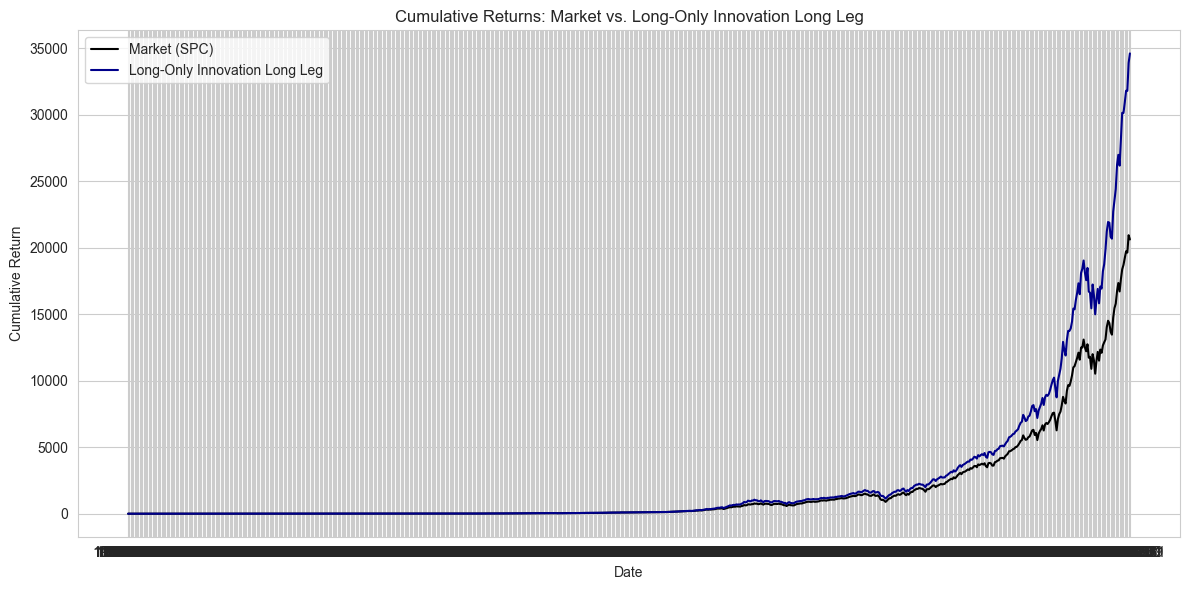

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extract positive weights only (long leg)
long_only_weights = innovation_weights.clip(lower=0)

# 2. Normalize so weights sum to 1 for each date (valid portfolio)
long_only_weights = long_only_weights.div(long_only_weights.sum(axis=1), axis=0)

# 3. Align return data columns
returns_aligned = data_numeric[long_only_weights.columns]

# 4. Compute portfolio returns
long_only_returns = (returns_aligned * long_only_weights).sum(axis=1)

# 5. Prepare DataFrame for comparison
returns_comparison = pd.DataFrame({
    "Market (SPC)": sp500_returns,
    "Long-Only Innovation Long Leg": long_only_returns
}).dropna()

# 6. Compute cumulative returns
cumulative_returns = (1 + returns_comparison).cumprod()

# 7. Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns["Market (SPC)"], label="Market (SPC)", color='black')
plt.plot(cumulative_returns.index, cumulative_returns["Long-Only Innovation Long Leg"], label="Long-Only Innovation Long Leg", color='darkblue')

plt.title("Cumulative Returns: Market vs. Long-Only Innovation Long Leg")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

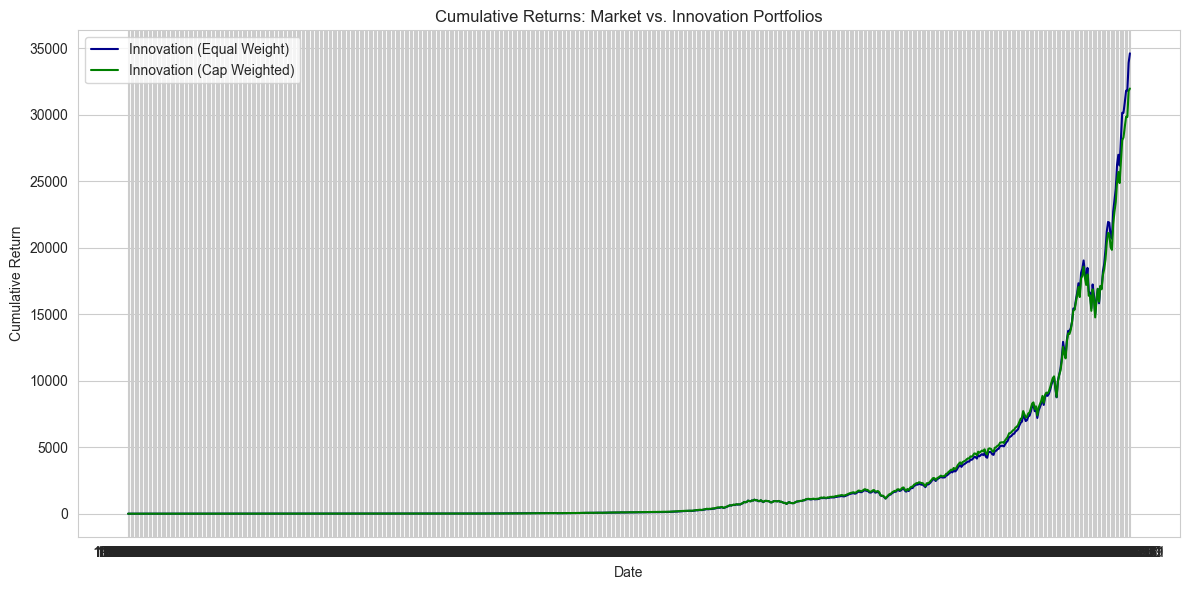

In [86]:
# Step 1: Long-only mask (same as before)
long_only_mask = innovation_weights.clip(lower=0) > 0

# Step 2: Cap weights, but only for long-only stocks
long_only_caps = cap_data_numeric * long_only_mask

# Step 3: Normalize across rows so weights sum to 1 (for long-only stocks only)
cap_weighted_long_only = long_only_caps.div(long_only_caps.sum(axis=1), axis=0)

# Align with return columns
returns_aligned = data_numeric[cap_weighted_long_only.columns]

# Compute returns
cap_weighted_long_only_returns = (returns_aligned * cap_weighted_long_only).sum(axis=1)


# Step 4: Add to returns_comparison
returns_comparison["Cap-Weighted Long-Only Innovation"] = cap_weighted_long_only_returns

# Step 5: Recompute cumulative
cumulative_returns = (1 + returns_comparison.dropna()).cumprod()

# Step 6: Plot
plt.figure(figsize=(12, 6))
# plt.plot(cumulative_returns.index, cumulative_returns["Market (SPC)"], label="Market (SPC)", color='black')
plt.plot(cumulative_returns.index, cumulative_returns["Long-Only Innovation Long Leg"], label="Innovation (Equal Weight)", color='darkblue')
plt.plot(cumulative_returns.index, cumulative_returns["Cap-Weighted Long-Only Innovation"], label="Innovation (Cap Weighted)", color='green')

plt.title("Cumulative Returns: Market vs. Innovation Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

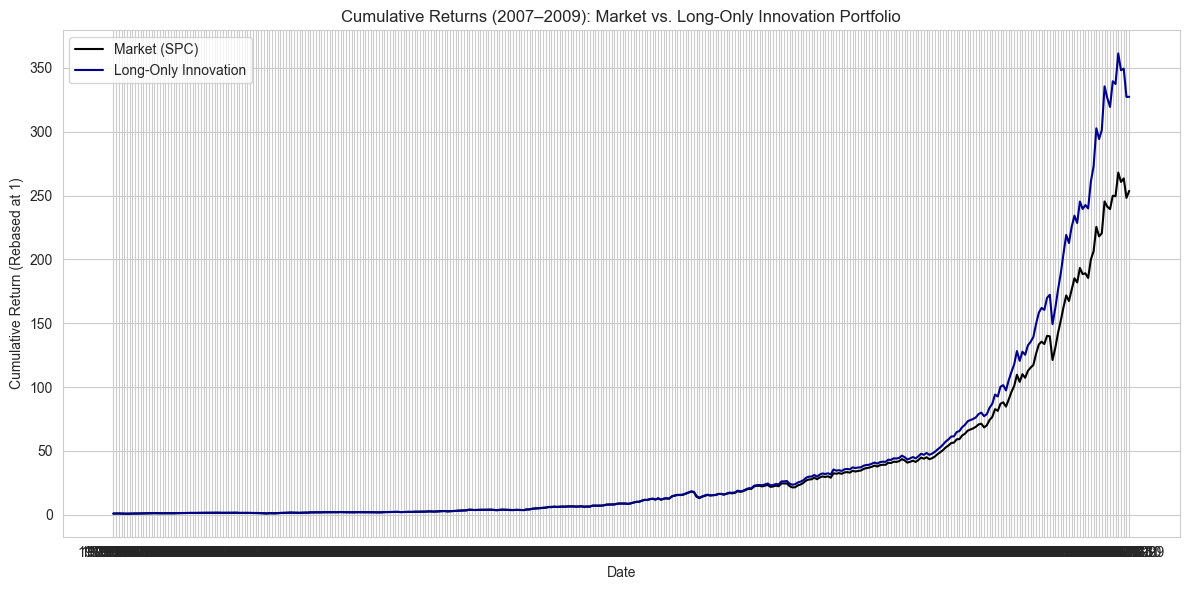

In [103]:
# Filter for the 2007–2009 time range
cr_filtered = returns_comparison.loc["1970-01-01":"2000-12-31"]
cumulative_window = (1 + cr_filtered).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_window.index, cumulative_window["Market (SPC)"], label="Market (SPC)", color="black")
plt.plot(cumulative_window.index, cumulative_window["Cap-Weighted Long-Only Innovation"], label="Long-Only Innovation", color="darkblue")

plt.title("Cumulative Returns (2007–2009): Market vs. Long-Only Innovation Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Rebased at 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
cap_weighted_long_only[["NVDA","AAPL"]]

,NVDA,AAPL
date,,
1960-01-29,0.000000,0.000000
1960-02-29,0.000000,0.000000
1960-03-31,0.000000,0.000000
1960-04-29,0.000000,0.000000
1960-05-31,0.000000,0.000000
...,...,...
2024-08-30,0.081372,0.096756
2024-09-30,0.081238,0.096054
2024-10-31,0.090544,0.095029


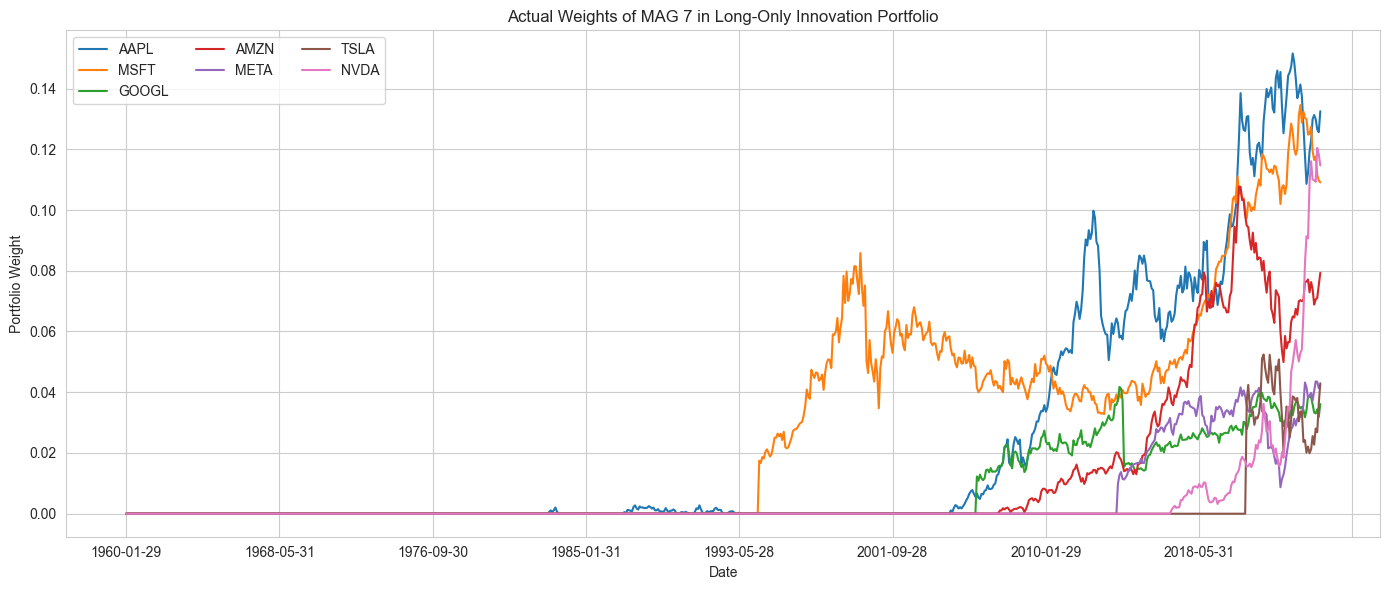

In [74]:
mag7 = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA']

long_only_weights = innovation_weights.clip(lower=0)
long_only_weights = long_only_weights.div(long_only_weights.sum(axis=1), axis=0)

mag7_weights_full = long_only_weights[mag7]  # already aligned with full portfolio

# Optional: add a check for missing tickers in the data
available_mag7 = [ticker for ticker in mag7 if ticker in mag7_weights_full.columns]

mag7_weights_full[available_mag7].plot(
    figsize=(14, 6),
    title="Actual Weights of MAG 7 in Long-Only Innovation Portfolio",
    ylabel="Portfolio Weight",
    xlabel="Date",
    grid=True
)
plt.legend(loc="upper left", ncol=3)
plt.tight_layout()
plt.show()

In [38]:
# This assumes you already clipped negative innovation weights and normalized
long_only_returns = (data_numeric[long_only_weights.columns] * long_only_weights).sum(axis=1)

rf = 0  # or a Series of same index as long_only_returns

window = 24

# Compute rolling mean and std dev
rolling_mean = long_only_returns.rolling(window).mean()
rolling_std = long_only_returns.rolling(window).std()

# Rolling Sharpe Ratio: (mean - rf) / std
rolling_sharpe = (rolling_mean - rf) / rolling_std

window = 24

# Compute rolling mean and std dev
rolling_mean = long_only_returns.rolling(window).mean()
rolling_std = long_only_returns.rolling(window).std()

# Rolling Sharpe Ratio: (mean - rf) / std
rolling_sharpe = (rolling_mean - rf) / rolling_std

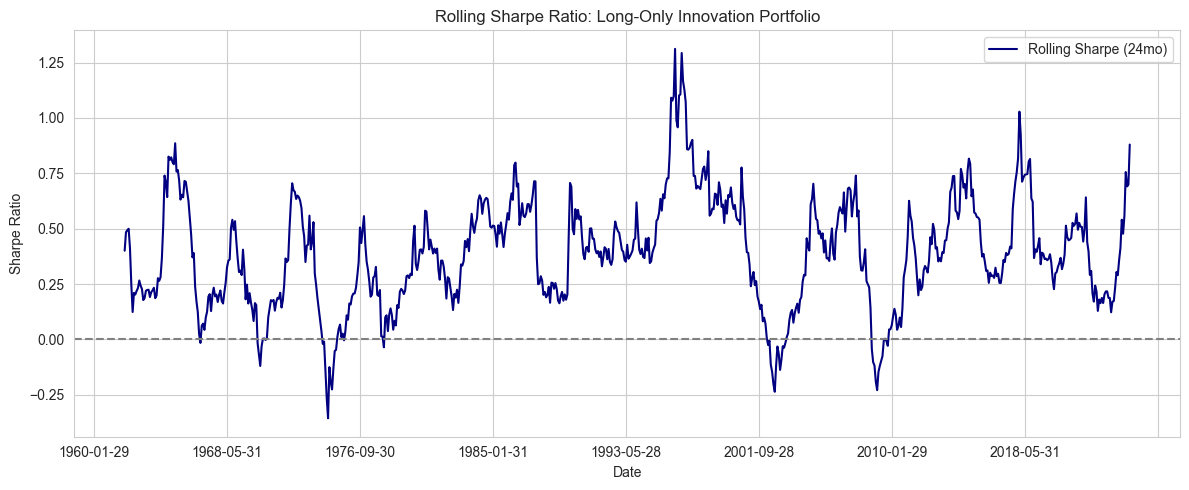

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
rolling_sharpe.plot(color='navy', label="Rolling Sharpe (24mo)")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Rolling Sharpe Ratio: Long-Only Innovation Portfolio")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Clip negative innovation weights
long_only_weights = innovation_weights.clip(lower=0)

# Normalize so weights sum to 1 each month
long_only_weights = long_only_weights.div(long_only_weights.sum(axis=1), axis=0)

# Align columns in return data
returns_aligned = data_numeric[long_only_weights.columns]

# Compute weighted returns
long_only_returns = (returns_aligned * long_only_weights).sum(axis=1)

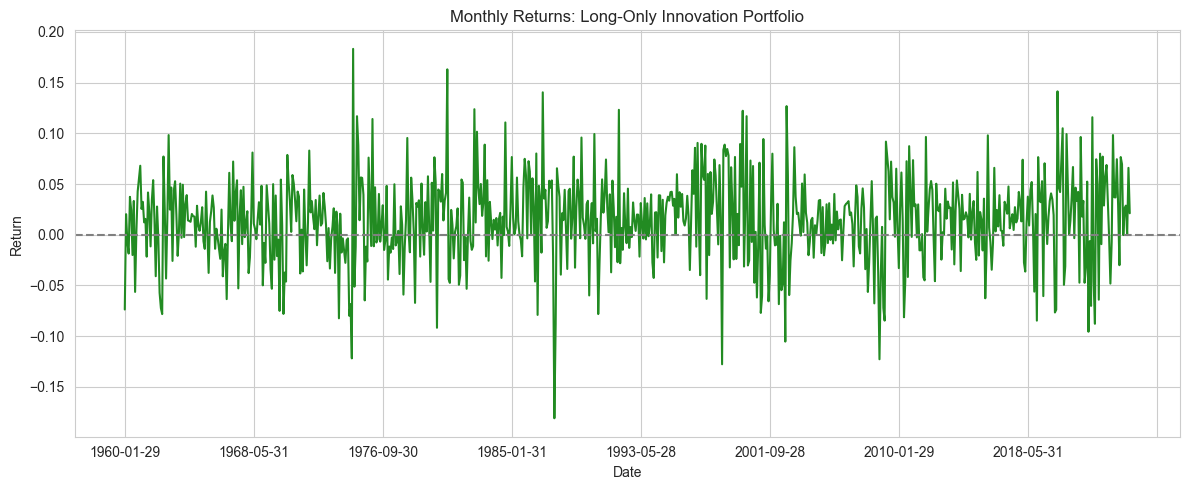

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
long_only_returns.plot(color='forestgreen')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Monthly Returns: Long-Only Innovation Portfolio")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()

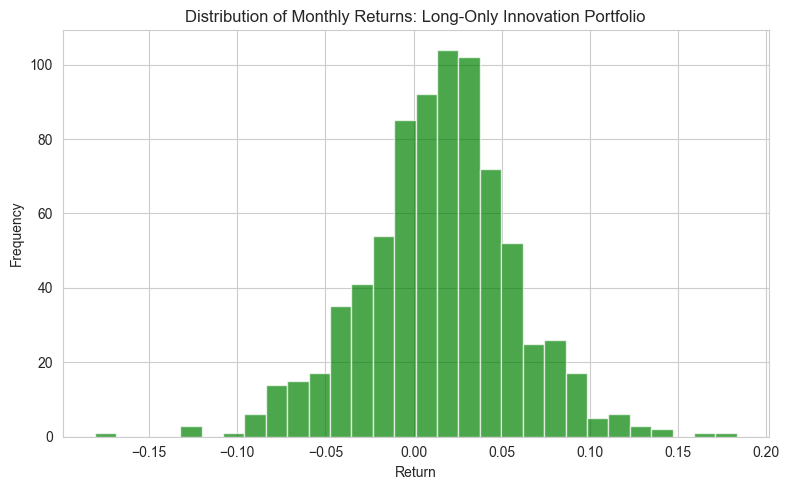

In [42]:
plt.figure(figsize=(8, 5))
plt.hist(long_only_returns, bins=30, color='green', alpha=0.7)
plt.title("Distribution of Monthly Returns: Long-Only Innovation Portfolio")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
long_only_returns

date
1960-01-29   -0.073715
1960-02-29    0.020320
1960-03-31   -0.007000
1960-04-29   -0.018516
1960-05-31    0.037400
                ...   
2024-08-30    0.025856
2024-09-30    0.028771
2024-10-31   -0.000282
2024-11-29    0.065995
2024-12-31    0.021212
Length: 780, dtype: float64

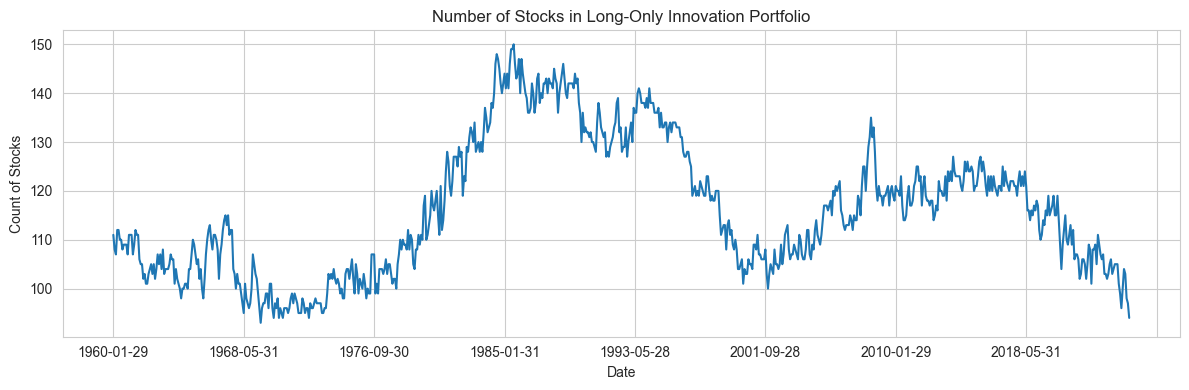

In [43]:
inclusion_matrix = (innovation_weights > 0).astype(int)

included_count = inclusion_matrix.sum(axis=1)

included_count.plot(figsize=(12, 4), title="Number of Stocks in Long-Only Innovation Portfolio")
plt.ylabel("Count of Stocks")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
date = "2000-06-30"  # pick any date in your data
included_stocks = inclusion_matrix.loc[date]
included_stocks = included_stocks[included_stocks == 1].index.tolist()

print(f"Stocks in the long-only portfolio on {date}:")
print(included_stocks)

Stocks in the long-only portfolio on 2000-06-30:
['JAVA', 'ORCL', 'MSFT', 'HON', 'EMC', 'T', 'WCOM', 'DELL', 'KO', 'DD', 'XOM', 'CMCSK', 'GE', 'GM', 'IBM', 'PEP', 'MO', 'AMGN', 'SLB', 'CVX', 'AMAT', 'TX', 'TXN', 'WYE', 'G', 'KMB', 'RTX', 'PG', 'PHA', 'CL', 'BMY', 'WBA', 'BA', 'ABT', 'GTE', 'PFE', 'EMR', 'JNJ', 'GLW', 'MMM', 'MRK', 'MSI', 'ENE', 'CCU', 'HWM', 'SGP', 'RD', 'CA', 'F', 'DIS', 'HPQ', 'WFC', 'S.1', 'TWX', 'MCD', 'ADP', 'JCI.1', 'MMC', 'FBF', 'JPM', 'TGT', 'BK.1', 'LLY', 'ADCT', 'FNM', 'MER', 'MU', 'WMT', 'NT', 'GAP.1', 'AXP', 'BUD', 'INTC', 'BAC.1', 'MDT', 'ADI', 'ONE', 'VZ', 'BLS.1', 'T.1', 'USW', 'HD.1', 'AIG', 'CPQ', 'MS.1', 'C.1', 'SCHW', 'TLAB', 'FRE', 'SLR', 'CSCO', 'XLNX', 'PARA', 'QCOM', 'NXTL', 'TWX.1', 'VRTS', 'NTAP', 'LU', 'YHOO', 'SEBL', 'PCS', 'A.1']


In [48]:
# Sum across rows (i.e., across time) to get number of months included
inclusion_counts = inclusion_matrix.sum(axis=0)

# Convert to tidy DataFrame
inclusion_summary = pd.DataFrame({
    'Ticker': inclusion_counts.index,
    'Months_Included': inclusion_counts.values
}).sort_values(by='Months_Included', ascending=False).reset_index(drop=True)

inclusion_summary

,Ticker,Months_Included
0,KO,780
1,CVX,780
2,MRK,780
3,PG,780
4,XOM,780
...,...,...
1858,RGLD,0
1859,AAF,0
1860,RVTY,0
1861,JOS,0


In [61]:
# Only keep returns for months when stock was included
included_returns = data_numeric * inclusion_matrix

months_positive_return = (included_returns > 0).sum(axis=0)

inclusion_summary = pd.DataFrame({
    'Ticker': inclusion_matrix.columns,
    'Months_Included': inclusion_matrix.sum(axis=0).values,
    'Months_Positive_Return': months_positive_return.values
}).sort_values(by='Months_Included', ascending=False).reset_index(drop=True)

inclusion_summary['Positive_Ratio'] = (
    inclusion_summary['Months_Positive_Return'] / inclusion_summary['Months_Included']
).round(3)  # Optional: round to 3 decimals

inclusion_summary.sort_values(by='Positive_Ratio', ascending=False).reset_index(drop=True).dropna()

,Ticker,Months_Included,Months_Positive_Return,Positive_Ratio
0,GTW,1,1,1.000
1,ESM,3,3,1.000
2,ADSK,1,1,1.000
3,SAF,2,2,1.000
4,PLTR,2,2,1.000
...,...,...,...,...
594,ADCT,3,1,0.333
595,VIAV,10,3,0.300
596,GR,17,5,0.294
597,RF,4,1,0.250


In [105]:
long_only_weights["IBM"]

date
1960-01-29    0.053156
1960-02-29    0.052774
1960-03-31    0.056314
1960-04-29    0.059329
1960-05-31    0.064387
                ...   
2024-08-30    0.003415
2024-09-30    0.003924
2024-10-31    0.003501
2024-11-29    0.003785
2024-12-31    0.003605
Name: IBM, Length: 780, dtype: float64